In [69]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

In [70]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_2'


# /roi_2

In [101]:
locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/

In [71]:
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240604.csv',index_col=0)
matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)


In [103]:
locations

area  center_x  center_y
label                           
1      11076     23744      1159
2      11394     23809      1231
3       6409     19364      1485
4       3812     19130      1523
5      17857     19238      1574
...      ...       ...       ...
67198   5295     37975     46550
67199   8077     38213     46576
67200  10502     38383     46597
67201   7186     38110     46616
67202   5797     38505     46628

[67202 rows x 3 columns]

In [296]:
matrix.set_index(matrix.index.astype(str),inplace=True)
locations.set_index(matrix.index.astype(str),inplace=True)

In [297]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]


Text(0, 0.5, 'number of cells with at least cutoff barcode spots')

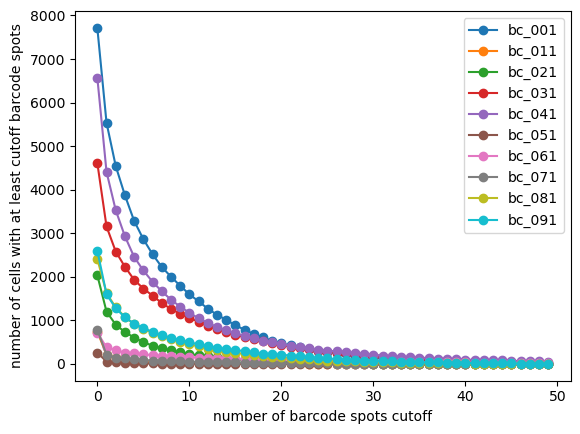

In [298]:
for bc in ['bc_{:03d}'.format(i) for i in range(1,97,10)]:

    vals = [len(matrix[matrix[bc]>c][bc].values) for c in range(50)]
    plt.plot(range(50),vals,label=bc,marker='o')
plt.legend()
plt.xlabel('number of barcode spots cutoff')
plt.ylabel('number of cells with at least cutoff barcode spots')

In [299]:
# find number of cells with at least cutoff spots per barcode

cutoff = 1
# cutoff = 3

n_cells = {}

for bc in ['bc_{:03d}'.format(i) for i in range(1,97)]:
    n_cells[bc] = len(matrix[matrix[bc]>cutoff][bc].values)




In [300]:
cell_barcodes = {}

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,locations,how='left',left_index=True,right_index=True)

In [301]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names']]

In [302]:
locations

area  center_x  center_y
1      11076     23744      1159
2      11394     23809      1231
3       6409     19364      1485
4       3812     19130      1523
5      17857     19238      1574
...      ...       ...       ...
67198   5295     37975     46550
67199   8077     38213     46576
67200  10502     38383     46597
67201   7186     38110     46616
67202   5797     38505     46628

[67202 rows x 3 columns]

<AxesSubplot: >

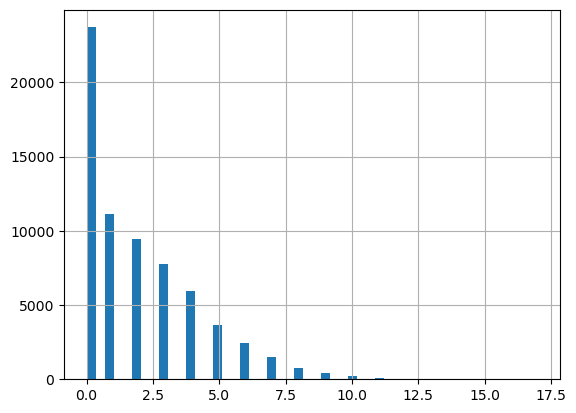

In [303]:
df['n_called_barcodes'].hist(bins=50)

In [307]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_2639/2925818511.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])


In [308]:
adata_genes.obs['area']

1        11076
2        11394
3         6409
4         3812
5        17857
         ...  
67198     5295
67199     8077
67200    10502
67201     7186
67202     5797
Name: area, Length: 67202, dtype: int64

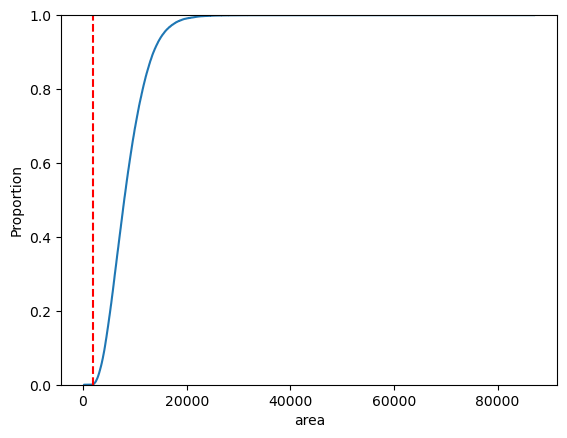

In [310]:
sns.ecdfplot(adata_genes.obs['area'],complementary=False)
plt.axvline(2000,color='red',linestyle='--')

In [311]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

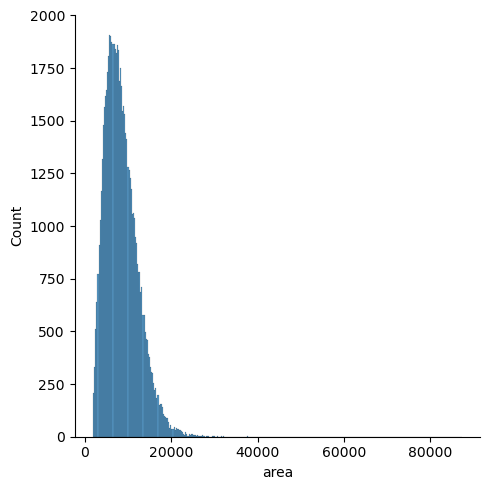

In [312]:
sns.displot(adata_genes.obs['area'])

In [314]:
sc.pp.calculate_qc_metrics(adata_genes,percent_top=None,log1p=False,inplace=True)

In [315]:
adata_genes

AnnData object with n_obs × n_vars = 67087 × 123
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

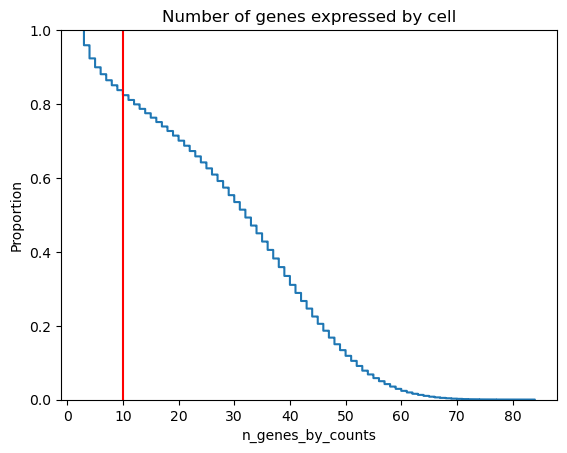

<Figure size 640x480 with 0 Axes>

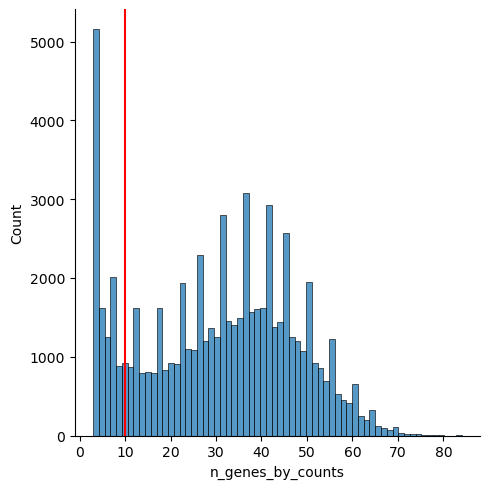

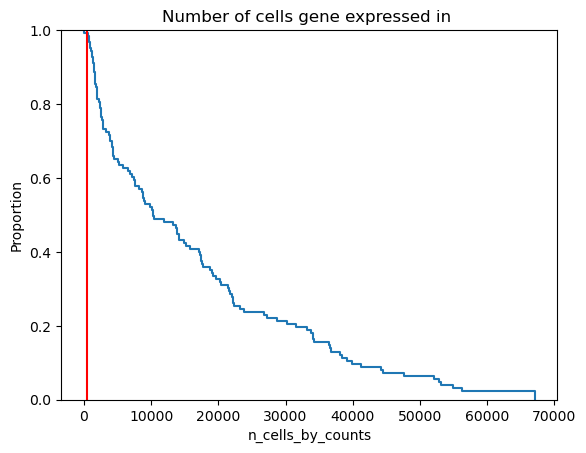

In [324]:


plt.figure()
plt.title('Number of genes expressed by cell')
sns.ecdfplot(adata_genes.obs['n_genes_by_counts'],complementary=True)
plt.axvline(10,color='r')
plt.figure()
sns.displot(adata_genes.obs['n_genes_by_counts'])
plt.axvline(10,color='r')

plt.figure()
# sns.displot(adata_genes.var['n_cells_by_counts'])
plt.title('Number of cells gene expressed in ')
sns.ecdfplot(adata_genes.var['n_cells_by_counts'],complementary=True)
plt.axvline(500,color='r')


# sns.displot()

In [325]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=10) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

In [326]:
sc.pp.normalize_total(adata_genes) # normalize with total number of (non-barcode) spots per cell 
sc.pp.scale(adata_genes) # scale genes across cells

# sc.pp.highly_variable_genes(adata_genes, n_top_genes=30)

## seurat v3 normalization is applied to the counts directly, 
# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')
# sc.pp.highly_variable_genes(adata_genes, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat_v3')
# sc.pp.pca(adata_genes)

# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')

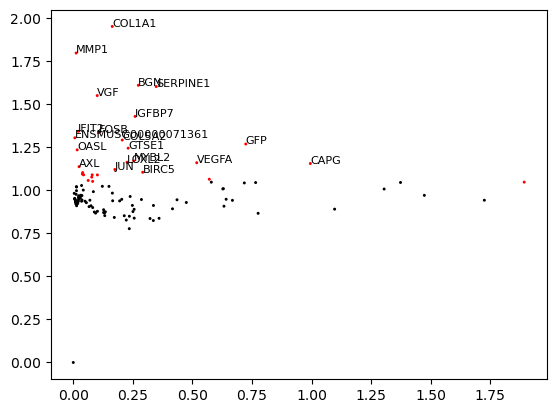

In [33]:
# # for entry in adata_genes.var

# color_dict = {True:'r',False:'k'}

# plt.figure()

# plt.scatter(adata_genes.var['means'].values,adata_genes.var['variances_norm'].values,
#             marker='.',s=5,color=[color_dict[x] for x in adata_genes.var['highly_variable']])

# for gene in adata_genes.var.index:
#     if adata_genes.var['highly_variable_rank'].loc[gene] < 20:
#         plt.text(adata_genes.var['means'].loc[gene],adata_genes.var['variances_norm'].loc[gene],gene,fontsize=8)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


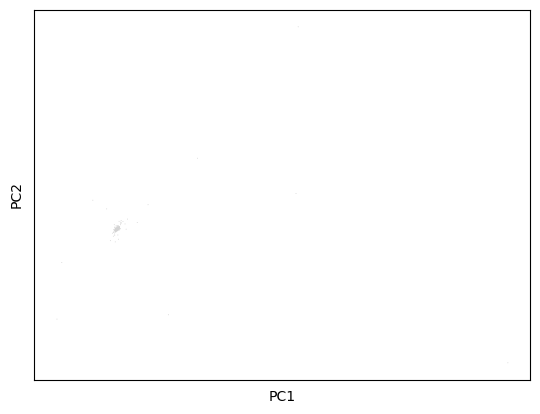

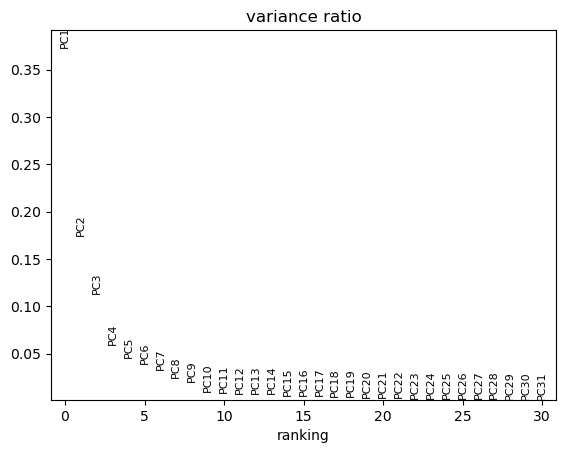

In [88]:
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [89]:
sc.pp.neighbors(adata_genes)
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


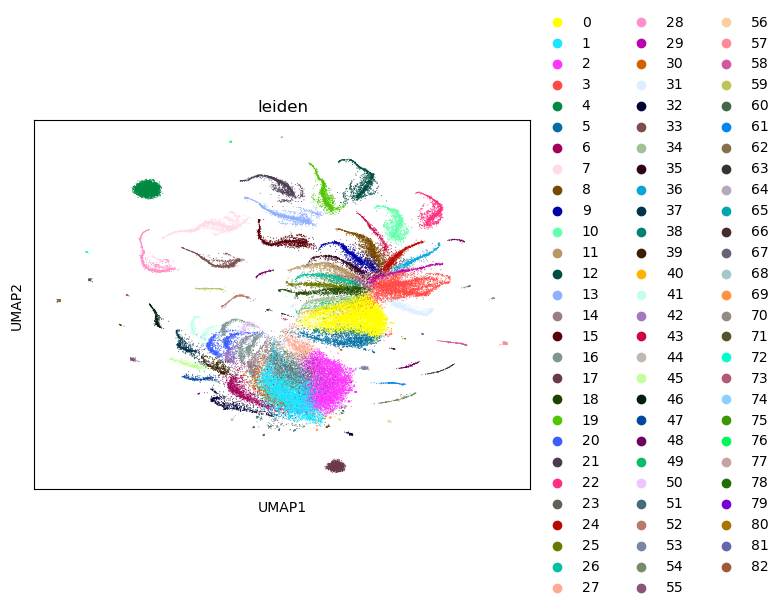

In [90]:
sc.pl.umap(adata_genes, color=["leiden"])

In [91]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [92]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


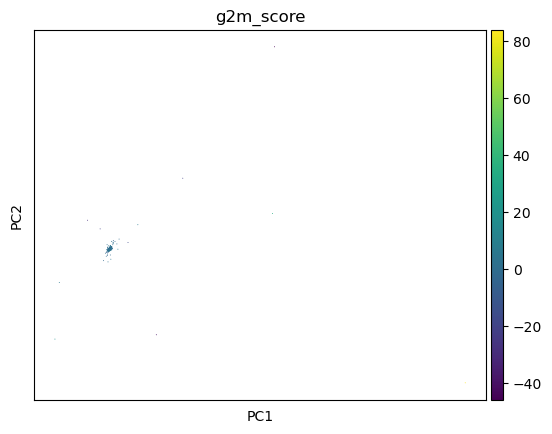

In [93]:
sc.pl.pca(adata_genes,color='g2m_score')

In [94]:
sc.pp.regress_out(adata_genes, ['g2m_score'])
sc.pp.scale(adata_genes)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


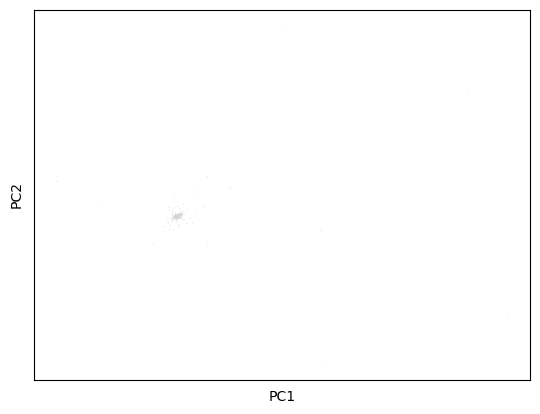

In [95]:
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)

In [96]:
sc.pp.neighbors(adata_genes)
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
# sc.tl.leiden(adata_genes, n_iterations=-1)

In [211]:
for res in [0.01,0.05,0.1, 0.5, 1.0]:
    sc.tl.leiden(
        adata_genes, key_added=f"leiden_res_{res:4.2f}", resolution=res, random_state=42
    )


/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2

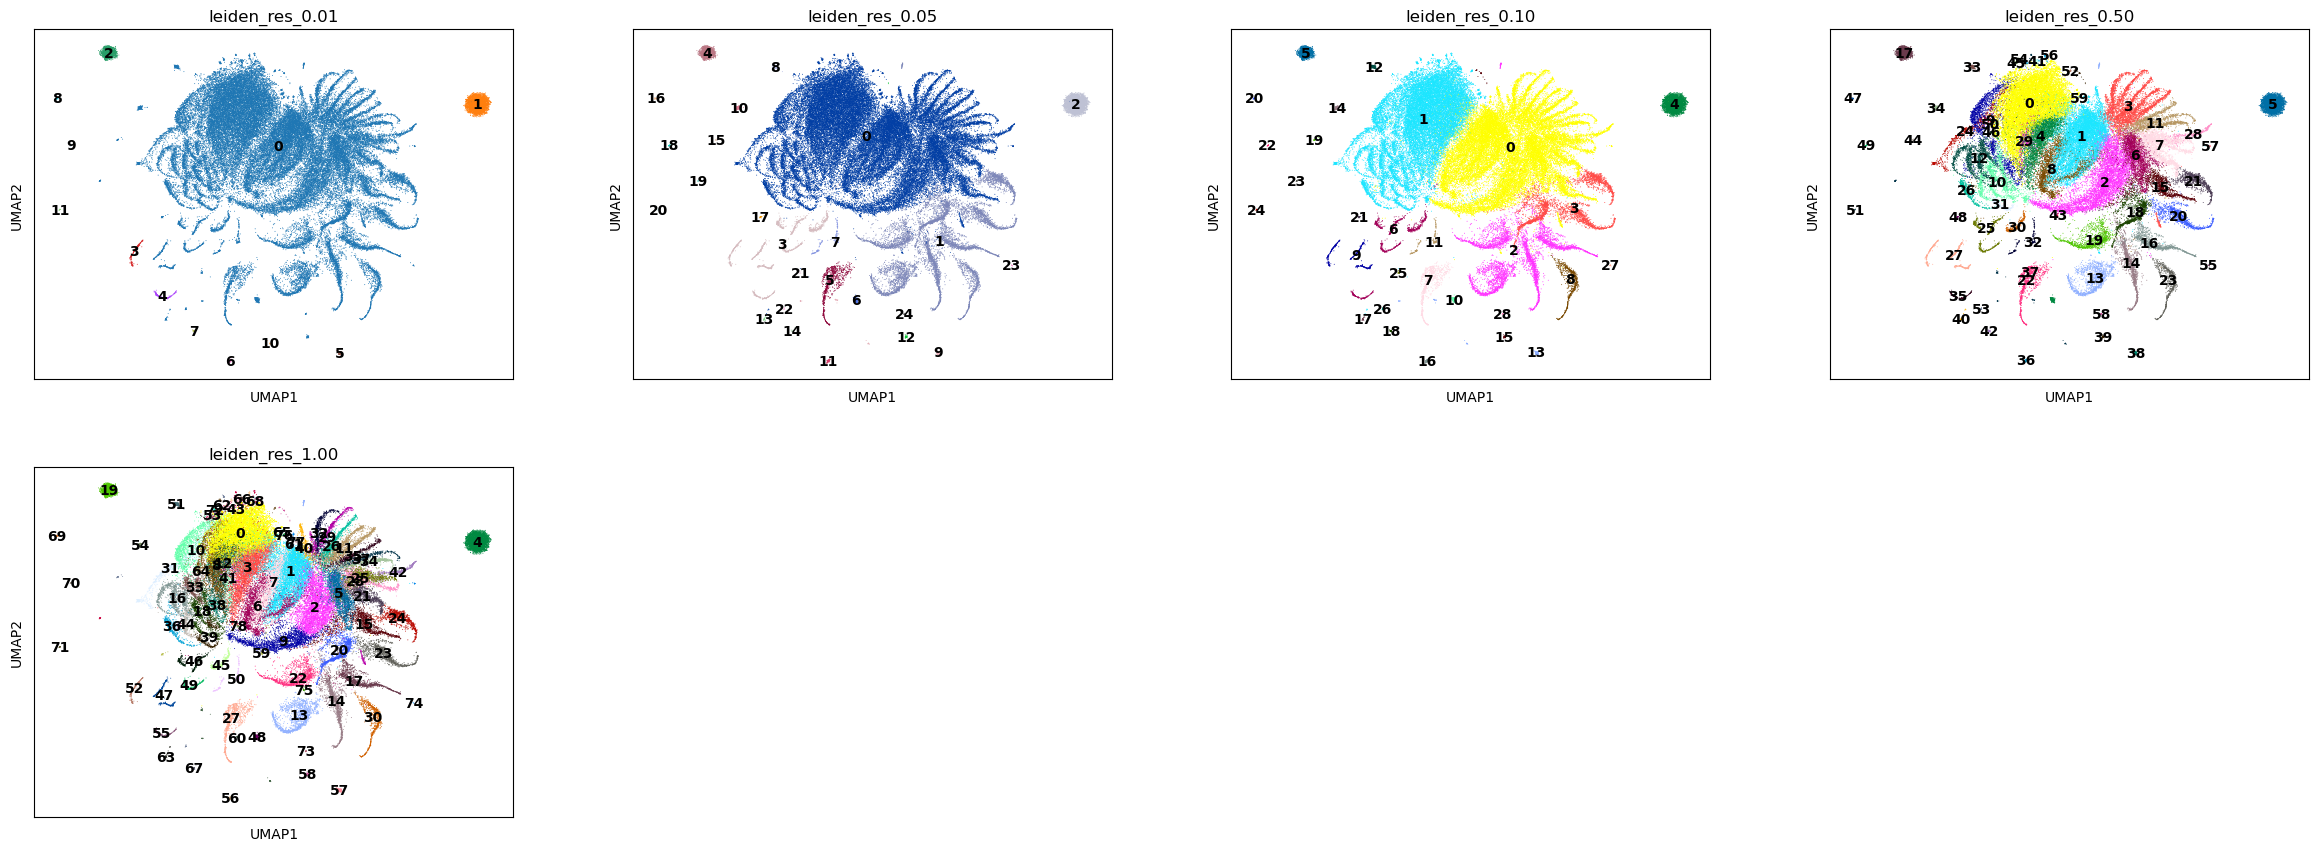

In [212]:
sc.pl.umap(
    adata_genes,
    color=["leiden_res_0.01","leiden_res_0.05","leiden_res_0.10", "leiden_res_0.50", "leiden_res_1.00"],
    legend_loc="on data",
)

In [100]:
adata_genes.obs['leiden_res_0.10']

1        1
2        1
3        0
4        1
5        9
        ..
67198    0
67199    1
67200    1
67201    1
67202    1
Name: leiden_res_0.10, Length: 67202, dtype: category
Categories (29, object): ['0', '1', '2', '3', ..., '25', '26', '27', '28']

In [106]:
adata_genes.obs['center_x'] = df['center_x'].values
adata_genes.obs['center_y'] = df['center_y'].values

In [127]:
c_dict = {str(x):c for x,c in enumerate(adata_genes.uns['leiden_res_0.10_colors'])}
c_list =[c_dict[x] for x in adata_genes.obs['leiden_res_0.10']]

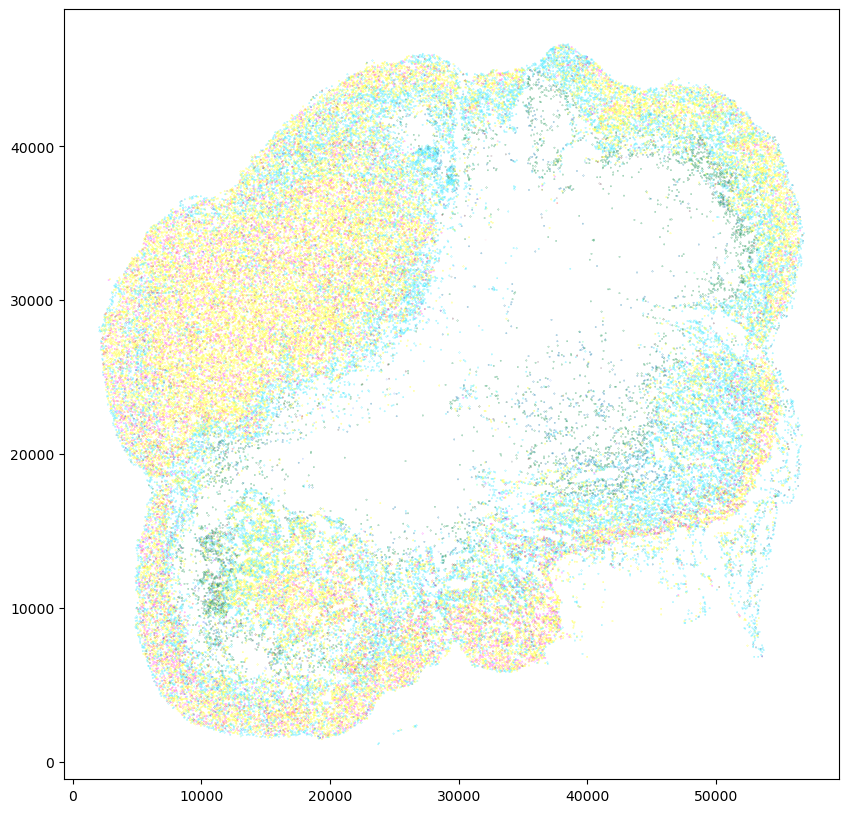

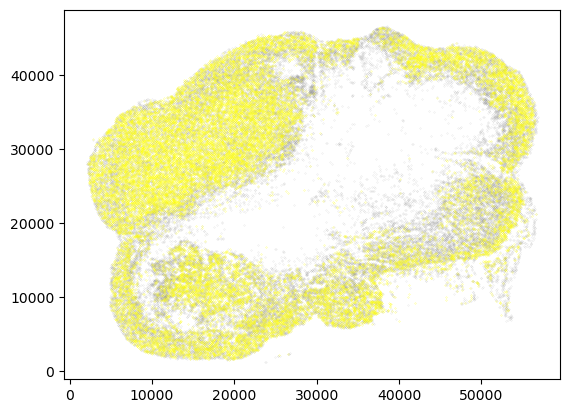

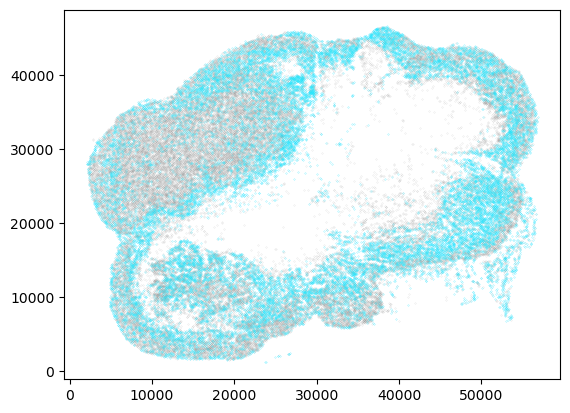

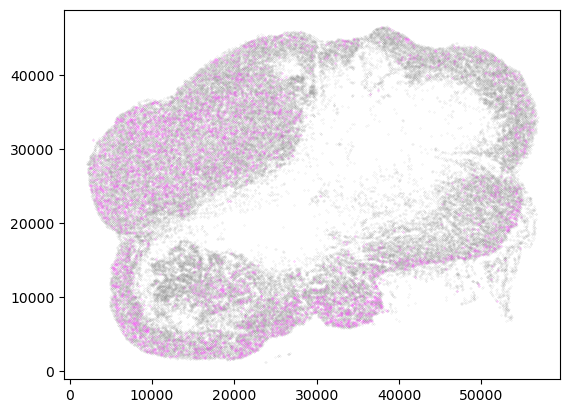

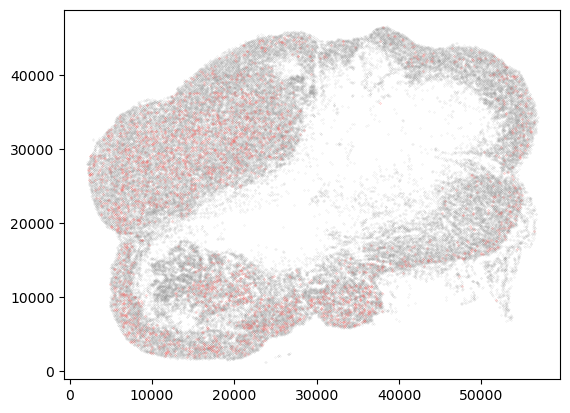

In [206]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
            c=c_list,
            s=0.1)

for cluster in [0,1,2,3]:
    plt.figure()
    not_cluster = adata_genes[adata_genes.obs['leiden_res_0.10']!=str(cluster)]
    plt.scatter(not_cluster.obs['center_x'],not_cluster .obs['center_y'],marker='.',
                c='gray',
                s=0.1,alpha=0.4)
    
    this_cluster = adata_genes[adata_genes.obs['leiden_res_0.10']==str(cluster)]
    plt.scatter(this_cluster.obs['center_x'],this_cluster.obs['center_y'],marker='.',
                c=c_dict[str(cluster)],
                s=0.1)
    
# plt.

In [ ]:
for bc in df['barcode_names'].unique():


    
    plt.scatter(df[df['barcode_names']==bc]['center_x'],df[df['barcode_names']==bc]['center_y'],label=bc,marker='o',s=1)

In [ ]:
plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
            c=c_list,
            s=0.1)

In [132]:
adata_genes

AnnData object with n_obs × n_vars = 67202 × 120
    obs: 'n_genes_by_counts', 'total_counts', 'leiden', 'g2m_score', 'leiden_res_0.10', 'leiden_res_0.50', 'leiden_res_1.00', 'center_x', 'center_y'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_res_0.10_colors', 'leiden_res_0.50_colors', 'leiden_res_1.00_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [123]:
{str(x):c for x,c in enumerate(adata_genes.uns['leiden_res_0.10_colors'])}

{'0': '#ffff00',
 '1': '#1ce6ff',
 '2': '#ff34ff',
 '3': '#ff4a46',
 '4': '#008941',
 '5': '#006fa6',
 '6': '#a30059',
 '7': '#ffdbe5',
 '8': '#7a4900',
 '9': '#0000a6',
 '10': '#63ffac',
 '11': '#b79762',
 '12': '#004d43',
 '13': '#8fb0ff',
 '14': '#997d87',
 '15': '#5a0007',
 '16': '#809693',
 '17': '#6a3a4c',
 '18': '#1b4400',
 '19': '#4fc601',
 '20': '#3b5dff',
 '21': '#4a3b53',
 '22': '#ff2f80',
 '23': '#61615a',
 '24': '#ba0900',
 '25': '#6b7900',
 '26': '#00c2a0',
 '27': '#ffaa92',
 '28': '#ff90c9'}

In [110]:
adata_genes.uns['leiden_res_0.10_colors']

['#ffff00',
 '#1ce6ff',
 '#ff34ff',
 '#ff4a46',
 '#008941',
 '#006fa6',
 '#a30059',
 '#ffdbe5',
 '#7a4900',
 '#0000a6',
 '#63ffac',
 '#b79762',
 '#004d43',
 '#8fb0ff',
 '#997d87',
 '#5a0007',
 '#809693',
 '#6a3a4c',
 '#1b4400',
 '#4fc601',
 '#3b5dff',
 '#4a3b53',
 '#ff2f80',
 '#61615a',
 '#ba0900',
 '#6b7900',
 '#00c2a0',
 '#ffaa92',
 '#ff90c9']

In [138]:
len(np.unique(df[df['n_called_barcodes']>3]['barcode_names'].values))

8022

In [196]:
name,count = np.unique(df[df['n_called_barcodes']>1]['barcode_names'].values,return_counts=True)

common_bc_combos = {}

for n,c in zip(name,count):
    if c > 40:
        # print(n,c)
        common_bc_combos[n] = c
    # print(n,c)  


In [197]:
bc_colors = sns.color_palette('tab20',n_colors=len(common_bc_combos))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(common_bc_combos.keys())}


bc_color_list = [bc_color_dict[bc] if bc in bc_color_dict.keys() else 'w' for bc in df['barcode_names'] ]

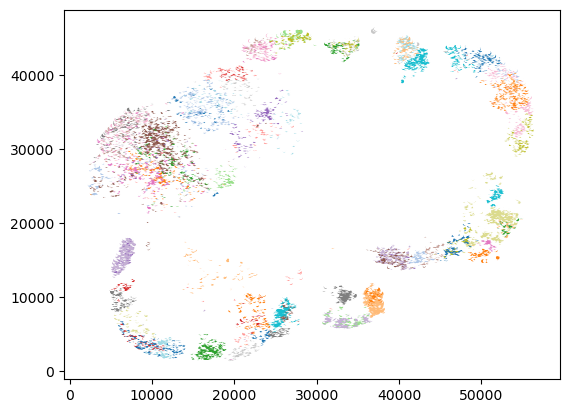

In [202]:
# fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
            c=bc_color_list,
            s=10.0)

# for cluster in [0,1,2,3]:
#     plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
#                 c=c_list,
#                 s=0.1)
# plt.

In [207]:
sc.tl.rank_genes_groups(adata_genes, groupby="leiden_res_0.10", method="wilcoxon")

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


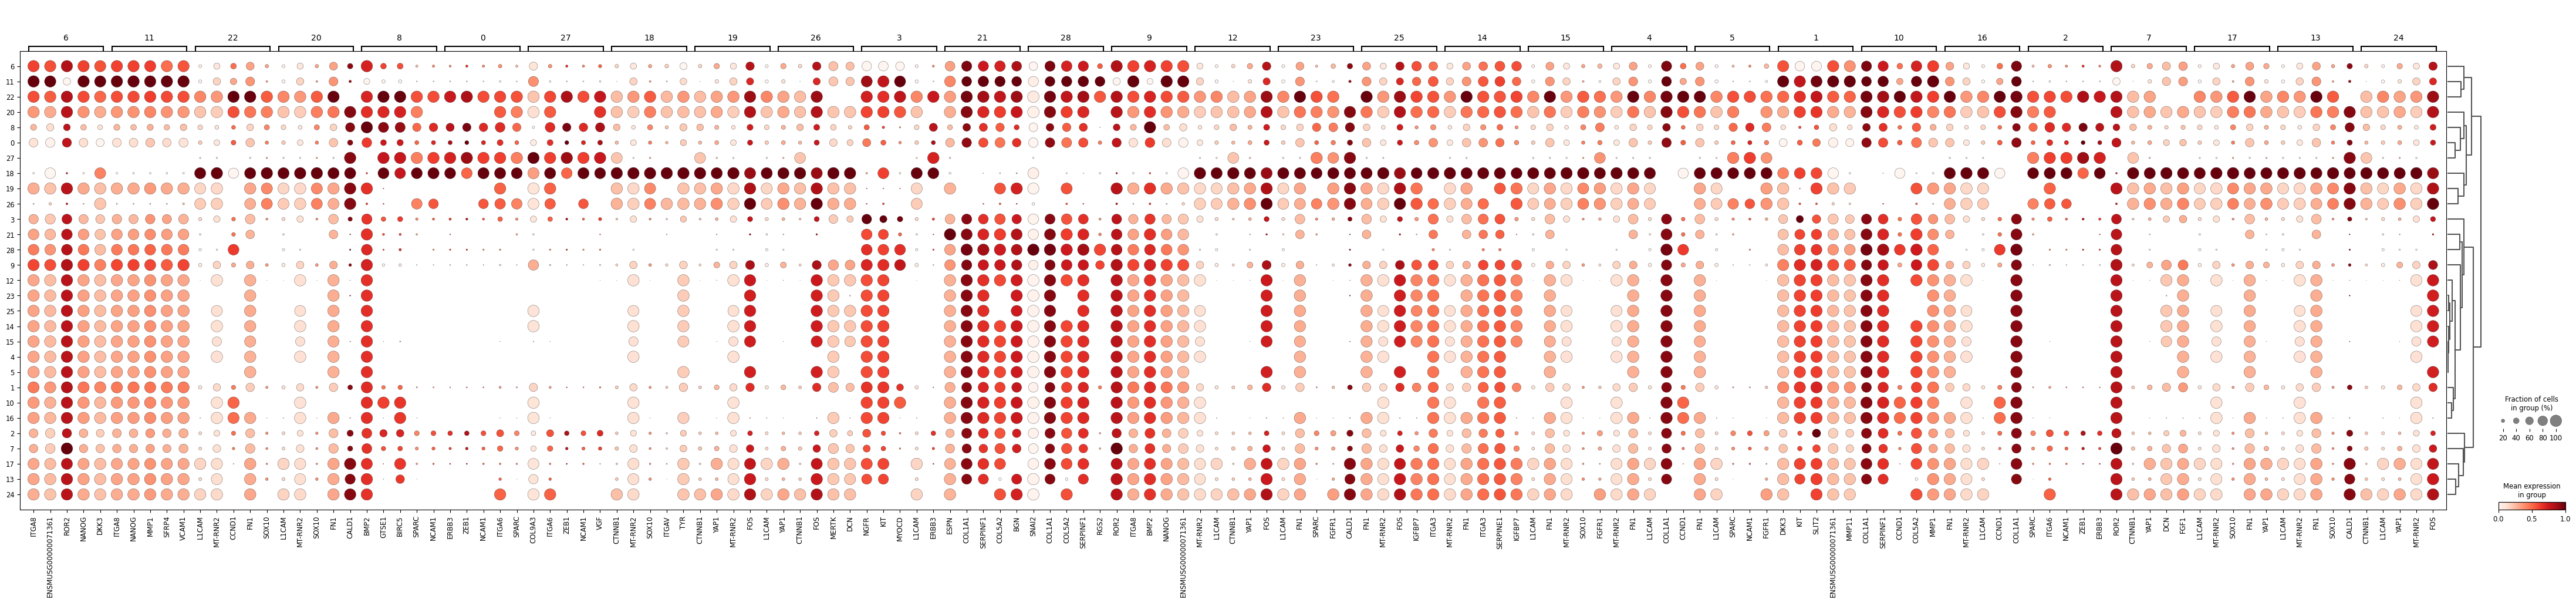

In [208]:
sc.pl.rank_genes_groups_dotplot(
    adata_genes, groupby="leiden_res_0.10", standard_scale="var", n_genes=5
)